# 확률분포를 이용한 생성 모델

MNIST 데이터셋을 이용하여 각 픽셀의 확률분포를 추출하고,
이 확률분포를 샘플링하여 이미지를 생성하는 코드 작성.

생성 모델에서 데이터의 확률 분포가 어떻게 사용되는지, 또 직관적으로 얼마나 의미있는 지표인지를 확인하기 위함

In [1]:
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
# 데이터 전처리를 위한 변환 정의 (이미지를 텐서로 변환)
transform = transforms.Compose([transforms.ToTensor()])

# MNIST 데이터셋 다운로드
train_dataset = MNIST(root='../../data', train=True, download=True, transform=transform)

In [28]:
def plot_prob_base_model(target):
    dataset = [img for img,label in train_dataset if label==target ]

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(dataset[0].squeeze(), cmap='gray')  # [1, 28, 28] 텐서를 28x28로 변환 (squeeze)
    axes[0].set_title(f"label : {target}")
    axes[0].axis("off")

    np_dataset = np.array(dataset)

    mean, var = np.mean(np_dataset, axis=0).reshape(-1), np.var(np_dataset, axis=0).reshape(-1)
    prob_img = np.array([np.random.normal(loc=mean[idx], scale=np.sqrt(var[idx])) for idx in range(784)]).reshape(28,28)
    prob_img = prob_img - prob_img[0]
    
    axes[1].imshow(prob_img, cmap='gray')
    axes[1].set_title(f"generated image")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()


In [31]:
def get_prob_base_model(target):
    dataset = [img for img,label in train_dataset if label==target ]

    np_dataset = np.array(dataset)

    mean, var = np.mean(np_dataset, axis=0).reshape(-1), np.var(np_dataset, axis=0).reshape(-1)
    diff = np.random.normal(loc=mean[0], scale=np.sqrt(var[0]))
    prob_img = np.array([np.random.normal(loc=mean[idx], scale=np.sqrt(var[idx])) - diff for idx in range(784)]).reshape(28,28)
    
    return prob_img


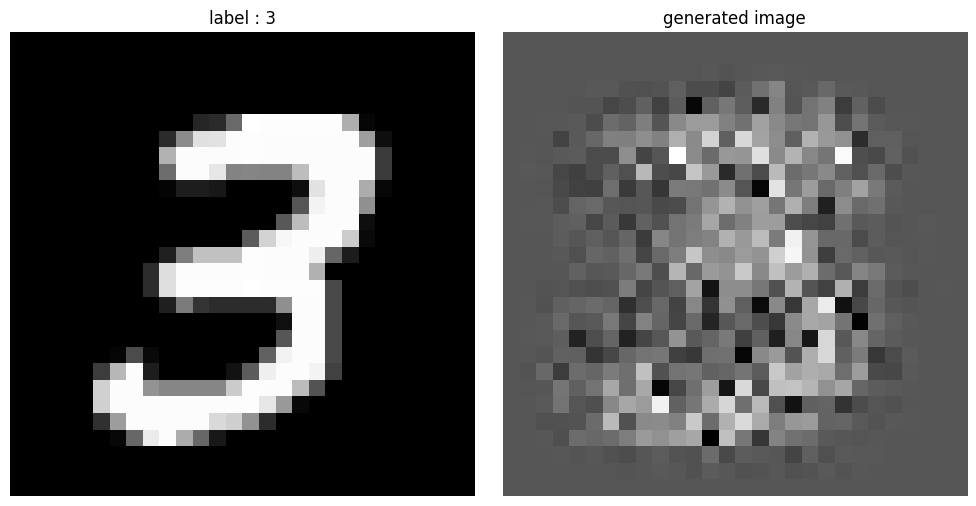

In [33]:
plot_prob_base_model(3)

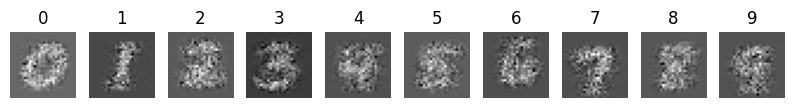

In [32]:
fig, axes = plt.subplots(1, 10, figsize=(10, 1))
for i in range(10):
    axes[i].imshow(get_prob_base_model(i), cmap="grey")
    axes[i].axis("off")
    axes[i].set_title(i)

# MNIST - 결론

완벽하지는 않지만 숫자의 형상을 띄운다는 점에서 확률분포가 의미있는 지표라고 생각됨

하지만 MNIST같은 저차원의 데이터셋이 아닌, 또한 생성할 객체의 위치나 방향이 다를 수 있는 데이터셋에 대해서는 <br>
확률분포로 접근하여 이미지를 생성하는 방법이 잘 작동할지에 의문이 생김

# 고차원 데이터셋을 통한 샘플링

MNIST 데이터셋보다 고차원 데이터셋인 CIFAR-10에 대하여 동일한 작업을 적용해보겠다.


In [2]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10

# 데이터 전처리를 위한 변환 정의 (이미지를 텐서로 변환 및 정규화)
transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 텐서로 변환
    transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768))  # 정규화
])

# CIFAR-10 데이터셋 다운로드 (train과 test 데이터셋 모두)
cifar_dataset = CIFAR10(root='../../data', train=True, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:11<00:00, 14598885.49it/s]


Extracting ../../data/cifar-10-python.tar.gz to ../../data


In [7]:
cifar_dataset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [8]:
def plot_cifar(img): # 3, 32, 32
    img = img/2 + 0.5
    img = img.numpy()
    plt.imshow(np.transpose(img, (1,2,0)))
    plt.axis("off")


def plot_prob_model_cifar(target_id):
    dataset = [img for img,label in cifar_dataset if label==target_id]
    torch_dataset = torch.stack(dataset)
    r,g,b = np.array(torch_dataset[:,0,:,:]), np.array(torch_dataset[:,1,:,:]), np.array(torch_dataset[:,2,:,:])

    r_mean, r_std = np.mean(r, axis=0).reshape(-1), np.var(r, axis=0).reshape(-1)
    g_mean, g_std = np.mean(g, axis=0).reshape(-1), np.var(g, axis=0).reshape(-1)
    b_mean, b_std = np.mean(b, axis=0).reshape(-1), np.var(b, axis=0).reshape(-1)

    ms_lst = [[r_mean, r_std], [g_mean, g_std], [b_mean, b_std]]

    img = torch.zeros(3,1024)

    for idx, (mean,std) in enumerate(ms_lst):
        for i in range(1024):
            img[idx][i] = np.random.normal(loc=mean[i], scale=np.sqrt(std[idx]))
    
    plot_cifar(img.reshape(3,32,32))


def get_prob_base_cifar(target_id):
    dataset = [img for img,label in cifar_dataset if label==target_id]
    torch_dataset = torch.stack(dataset)
    r,g,b = np.array(torch_dataset[:,0,:,:]), np.array(torch_dataset[:,1,:,:]), np.array(torch_dataset[:,2,:,:])

    r_mean, r_std = np.mean(r, axis=0).reshape(-1), np.var(r, axis=0).reshape(-1)
    g_mean, g_std = np.mean(g, axis=0).reshape(-1), np.var(g, axis=0).reshape(-1)
    b_mean, b_std = np.mean(b, axis=0).reshape(-1), np.var(b, axis=0).reshape(-1)

    ms_lst = [[r_mean, r_std], [g_mean, g_std], [b_mean, b_std]]

    img = torch.zeros(3,1024)

    for idx, (mean,std) in enumerate(ms_lst):
        for i in range(1024):
            img[idx][i] = np.random.normal(loc=mean[i], scale=np.sqrt(std[idx]))

    return img.reshape(3,32,32)
    


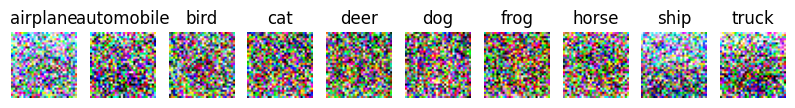

In [9]:
fig, axes = plt.subplots(1,10, figsize=(10,1))

for i in range(10):
    img = get_prob_base_cifar(i)
    img = img/2 + 0.5
    img = img.numpy()
    axes[i].imshow(np.clip(np.transpose(img, (1,2,0)),0,1))
    axes[i].axis("off")
    axes[i].set_title(f"{cifar_dataset.classes[i]}")
    

# CIFAR - 결론

CIFAR10 데이터셋에 대해 MNIST에 적용했던 각 픽셀의 확률분포를 뽑고 그에 대해 샘플링 하는 방식으로 이미지를 생성해보았다.

그 결과 어떤 형태인지도 알아보기 어려운 이미지가 생성되었다. 

CIFAR10 데이터셋의 경우 다음과 같이 모양, 방향, 색상 등 굉장히 다양하다.

따라서 이러한 이미지 샘플들에 대해 일반화된 확률분포를 얻어내서 그 확률분포 자체르 샘플링하여 이미지를 생성하는 방식은 불가능해보인다.

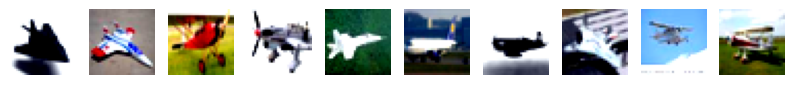

In [10]:
dataset = [img for img,label in cifar_dataset if label == 0]
_, axes = plt.subplots(1,10, figsize=(10,1))
for i in range(10):
    img = dataset[i] / 2 + 0.5
    img = img.numpy()
    axes[i].imshow(np.clip(np.transpose(img, (1,2,0)),0,1))
    axes[i].axis("off")